# Comparing VBD Outputs: Waymax vs GPUDrive

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import waymax
import numpy as np
import math
import mediapy
from tqdm import tqdm
import dataclasses
import os
import shutil
from pathlib import Path
import pickle
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from waymax import config as _config
from waymax import dataloader, datatypes, visualization, dynamics
from waymax.datatypes.simulator_state import SimulatorState
from waymax.config import EnvironmentConfig, ObjectType

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

# VBD dependencies
from integrations.models.vbd.sim_agent.waymax_env import WaymaxEnvironment
from integrations.models.vbd.data.dataset import WaymaxTestDataset
from integrations.models.vbd.waymax_visualization.plotting import plot_state
from integrations.models.vbd.sim_agent.sim_actor import VBDTest, sample_to_action
from integrations.models.vbd.model.utils import set_seed

# GPUDrive dependencies
import gpudrive
from gpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

# Plotting
sns.set("notebook")
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
#%config InlineBackend.figure_format = 'svg'

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

2025-03-03 17:32:26.371204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741041146.388907   44104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741041146.394044   44104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 17:32:26.413108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Configurations

In [2]:
DATA_DIR = 'data/processed' # Base data path
CKPT_PATH = 'integrations/models/vbd/weights/epoch=18.ckpt'

SCENARIO_ID = 'efc5cbe01b4a526f'

FPS = 20
INIT_STEPS = 11 # Warmup period
MAX_CONTROLLED_OBJECTS = 32

### Load pre-trained VBD model

In [3]:
# Load model
model = VBDTest.load_from_checkpoint(CKPT_PATH, torch.device('cpu'))
_ = model.cpu()
_ = model.eval();

# Model settings
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Ensure reproducability
#set_seed(5)

In [4]:
def save_side_by_side_gif(frames1, frames2, output_path, fps=FPS):
    """
    Saves two arrays of frames as a single side-by-side GIF.
    The second frame array is resized to match the dimensions of the first frame array.
    
    Parameters:
    frames1 (list of np.ndarray): First array of frames (images).
    frames2 (list of np.ndarray): Second array of frames (images).
    output_path (str): Path to save the output GIF.
    fps (int): Frames per second for the GIF.
    """
    # Ensure both arrays have the same number of frames
    if len(frames1) != len(frames2):
        raise ValueError("The two frame arrays must have the same number of frames.")
    
    # Combine frames side by side
    combined_frames = []
    for frame1, frame2 in zip(frames1, frames2):
        # Get the dimensions of frame1
        height1, width1 = frame1.shape[:2]

        if frame2.shape[0] != height1 or frame2.shape[1] != width1:
            # Resize frame2 to match the dimensions of frame1
            pil_image = Image.fromarray(frame2)
            frame2 = np.array(pil_image.resize((width1, height1)))
        
        # Concatenate frames horizontally
        combined_frame = np.hstack((frame1, frame2))
        combined_frames.append(combined_frame)
    
    # Save the combined frames as a GIF
    mediapy.write_video(output_path, combined_frames, fps=fps, codec="gif")
    print(f"GIF saved at {output_path}")

### Make Videos

In [5]:
# Create waymax test "dataset" obj (need for utils)
dataset = WaymaxTestDataset(
    data_dir = 'data/processed/debug/waymax', 
    anchor_path = 'integrations/models/vbd/data/cluster_64_center_dict.pkl',
    max_object=MAX_CONTROLLED_OBJECTS,
)
#Init Waymax env
env_config = EnvironmentConfig(
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=INIT_STEPS+1,
    max_num_objects=MAX_CONTROLLED_OBJECTS,
)
waymax_env = WaymaxEnvironment(
    dynamics_model=dynamics.StateDynamics(),
    config=env_config,
    log_replay = True,
)

with open(f'{DATA_DIR}/debug/waymax/waymax_scenario_{SCENARIO_ID}.pkl', 'rb') as f:
    scenario = pickle.load(f)

#Generate video with vbd trajectories
init_state = waymax_env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
init_state,
current_index=init_state.timestep,
use_log=False
)
is_controlled = sample['agents_interested'] > 0
selected_agents = sample['agents_id'][is_controlled]
state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        sample = dataset.process_scenario(
        current_state, 
        current_index = current_state.timestep,
        use_log=False,
        selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    # Get action
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(
    action_sample, 
    is_controlled, 
    agents_id=selected_agents, 
    max_num_objects=MAX_CONTROLLED_OBJECTS
    )
    # Step the simulator
    current_state = waymax_env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

waymax_frames = [plot_state(state) for state in state_logs]


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Found 52 scenarios


Diffusion: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


In [6]:
#Init GPUDrive env
env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    remove_non_vehicles=False, # Control vehicles, pedestrians, and cyclists
    return_vbd_data=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
    dist_to_goal_threshold=1e-5, # Trick to make sure the agents don't disappear when they reach the goal
    collision_behavior="ignore", # Ignore collisions
    init_mode = 'all_objects'
)
        
scene_config = SceneConfig(batch_size=1, dataset_size=1, path="data/processed/temp", num_scenes=1)
# Make env
gpudrive_env = GPUDriveTorchEnv(
    config=env_config,
    data_loader = SceneDataLoader(
        root="data/processed/temp",
        batch_size=scene_config.batch_size,
        dataset_size=scene_config.dataset_size,
    ),
    render_config=RenderConfig(resolution=(400, 400)),
    max_cont_agents=MAX_CONTROLLED_OBJECTS, # Maximum number of agents to control per scene
    device="cpu",
)
#Generate video with VBD trajectories 
init_state = gpudrive_env.reset()
selected_agents = torch.nonzero(gpudrive_env.cont_agent_mask[0, :]).flatten().tolist()
# Obtain all info for diffusion model (warmup)
gpudrive_sample_batch = gpudrive_env.sample_batch
# Obtain predicted trajectories
pred = model.sample_denoiser(gpudrive_sample_batch)#, x_t=x_t)
vbd_traj_pred = pred['denoised_trajs'].cpu().numpy()[0]
is_controlled = gpudrive_sample_batch['agents_interested'] > 0
agent_indices = gpudrive_sample_batch['agents_id'][0]

pred_trajs = torch.zeros((gpudrive_env.max_agent_count, env_config.episode_len-INIT_STEPS, 10))
pred_trajs[agent_indices, :, :2] = torch.Tensor(vbd_traj_pred[:, :, :2]) # pos x, y
pred_trajs[agent_indices, :, :2] -= gpudrive_env.sim.world_means_tensor().to_torch()[0, :2] #re-mean the predicted trajectory positions
pred_trajs[agent_indices, :, 3] = torch.Tensor(vbd_traj_pred[:, :, 2]) # yaw 
pred_trajs[agent_indices, :, 4:6] = torch.Tensor(vbd_traj_pred[:, :, 3:5]) # vel x, y
pred_trajs = pred_trajs.unsqueeze(0)

gpudrive_frames = []

# Step
for t in range(env_config.episode_len-INIT_STEPS):
    gpudrive_env.step_dynamics(pred_trajs[:, :, t, :])
    fig = gpudrive_env.vis.plot_simulator_state(
        env_indices=[0],
        time_steps=[t],
        zoom_radius=70,
    )[0]
    
    gpudrive_frames.append(img_from_fig(fig))

Diffusion: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


In [7]:
# Save gif for comparison
save_side_by_side_gif(waymax_frames, gpudrive_frames, f'integrations/models/videos/{SCENARIO_ID}.gif')

GIF saved at integrations/models/videos/efc5cbe01b4a526f.gif


## Plotting VBD trajectory as part of agent obs

In [108]:
def transform_to_ego_frame(trajectory: torch.Tensor, ego_pos: torch.Tensor, ego_yaw: torch.Tensor) -> torch.Tensor:
    """
    Transform trajectory from global coordinates to ego-centric frame.
    Args:
    trajectory: Shape (time_steps, 2) containing x,y coordinates in global frame
    ego_pos: Shape (2,) containing ego x,y position
    ego_yaw: Shape (1,) containing ego yaw angle in radians
    Returns:
    transformed_trajectory: Shape (time_steps, 2) in ego-centric frame
    """
    # Shift to ego position
    centered_trajectory = trajectory - ego_pos
    
    # Create rotation matrix
    cos_yaw = torch.cos(ego_yaw)
    sin_yaw = torch.sin(ego_yaw)
    
    # Modified rotation matrix:
    # Forward direction (+x) corresponds to the direction of ego_yaw
    # Rightward direction (-y) is perpendicular and to the right
    rotation_matrix = torch.tensor([
        [sin_yaw, cos_yaw],     # Maps forward to +x
        [cos_yaw, -sin_yaw]     # Maps rightward to -y
    ], device=trajectory.device)
    
    # Rotate trajectory
    transformed_trajectory = torch.matmul(centered_trajectory, rotation_matrix.T)
    return transformed_trajectory

In [109]:
agent_indices

tensor([ 2,  3,  4,  5,  7,  8, 10, 11, 13, 15, 16, 22, 23, 24, 25, 26, 27, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 58, 61, 62, 63],
       dtype=torch.int32)

In [110]:
# plotting vbd trajectory as part of observation
agent_index = agent_indices[0]

vbd_trajectory = pred_trajs[0, agent_index, :, :2]

pos_xy = gpudrive_sample_batch['agents_history'][0, agent_index, :, :2] - gpudrive_env.sim.world_means_tensor().to_torch()[0, :2]
yaw = gpudrive_sample_batch['agents_history'][0, agent_index, -1, 2]

transformed_trajectory = transform_to_ego_frame(vbd_trajectory, vbd_trajectory[0], yaw)

init_state = gpudrive_env.reset()
vbd_trajectory[0], transformed_trajectory[0], pos_xy[-1]

(tensor([-21.4629,  13.4917]), tensor([0., 0.]), tensor([-18.6807,  48.0344]))

In [111]:
# plotting vbd trajectory as part of observation (local frame)
init_state = gpudrive_env.reset()
fig = gpudrive_env.vis.plot_agent_observation(
    agent_idx=agent_index,
    env_idx=0,
    trajectory=transformed_trajectory,
    figsize = (4, 4)
)

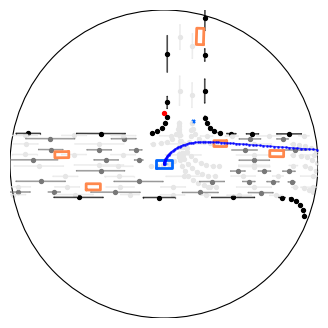

In [112]:
fig

In [29]:
transformed_trajectory

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0